In [29]:
%load_ext Cython
# Imports
import io
import statsmodels.api as sm
import multiprocessing as mp
import gc
from redundancy import hsic, datahelpers
import time
from matplotlib import pyplot as plt
from parallelqueue.base_models import *
from parallelqueue.monitors import *
ncpus = mp.cpu_count()


The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [30]:
# User-set params
simrep = 20 # set to cores utilized in parallel to limit amount held in memory
if simrep>ncpus: print("simrep should be <= to be safe")
ToOrder = [500] # N values to test
# WARNING: N values too high can result in memory leaks!
seed = 1111
maxtime = 1000 # max time used across all sims
rng = hsic.spanning_grid_uniform(maxtime - 1, 900,0.25) # times to sample
print(rng[:10])
alpha = 0.1


[900.2444881433743, 900.4435870938131, 900.5219122173036, 900.8141787586595, 901.1057100028416, 901.4250721288577, 901.6069130246561, 901.9827858341409, 902.005573319166, 902.3290370542572]


In [31]:
print(f"Using ncpus={simrep}")
class Concurrent:
    def __init__(self, maxtime=1000, rho = 0.9, d=2, r=2,
                 order=range(2, 1000, 2), seed=123):
        self.rhoJSim = None
        self.r = r
        self.order = order
        self.d = d
        self.rho = rho
        self.maxtime = maxtime
        self._ts = None
        self.seed = seed

    def WriteEach(self, simrep=1, of=["TSim"], ts=True):
        """                   v rep within run
        res['Thresh(2,2)'][0][0].keys()
                           ^run (N-size)
        Out[9]: dict_keys(['ReplicaSets', 'TimeQueueSize'])"""
        self._ts = ts
        self._sims = simrep
        labels = {self.RSim: f"Redundancy({self.d})", self.JSim: f"JSQ({self.d})",
                  self.TSim: f"Thresh({self.d},{self.r})"}
        self.res = {}
        for sim in [self.__getattribute__(i) for i in of]:
            print(f"Running {sim}")
            self.res[labels[sim]] = self.ParallelSim(sim)

    def DoEach(self, of=["TSim"], iters=1):
        self._ts = False
        labels = {self.RSim: f"Redundancy({self.d})", self.JSim: f"JSQ({self.d})",
                  self.TSim: f"Thresh({self.d},{self.r})"}
        self.res = {}
        for sim in [self.__getattribute__(i) for i in of]:
            print(f"Running {sim}")
            results = self.ParallelSim(sim)
            self.res[labels[sim]] = pd.DataFrame(results)
        for k, v in self.res.items():
            plt.plot(v, label=k)
        plt.legend()
        if iters == 1:
            plt.title("Average Time in System as N → ∞")

    def RSim(self, reps):
        mons = [TimeQueueSize]
        testvalues = []
        for N in (self.order):
            _sim = RedundancyQueueSystem(maxTime=self.maxtime, parallelism=N, seed=self.seed + 2331 * N + reps,
                                         d=self.d,
                                         Arrival=random.expovariate,
                                         AArgs=(self.rho*N)/self.d, Service=random.expovariate, SArgs=1,
                                         Monitors=mons)
            _sim.RunSim()
            testvalues.append(_sim.MonitorOutput)
        if not self._ts:
            return np.array(testvalues)
        else:
            return np.mean(testvalues)

    def JSim(self, reps):
        mons = [TimeQueueSize]
        testvalues = []
        for N in (self.order):
            _sim = JSQd(maxTime=self.maxtime, parallelism=N, seed=self.seed + 2331 * N + reps, d=self.d,
                        Arrival=random.expovariate,
                        AArgs=(self.rho*N)/self.d, Service=random.expovariate, SArgs=1,
                        Monitors=mons)
            _sim.RunSim()
            testvalues.append(_sim.MonitorOutput)
        if not self._ts:
            return np.array(testvalues)
        else:
            return np.mean(testvalues)

    def TSim(self, reps):
        mons = [TimeQueueSize]
        testvalues = []
        for N in (self.order):
            _sim = ParallelQueueSystem(maxTime=self.maxtime, parallelism=N, seed=self.seed + 2331 * N + reps,
                                         d=self.d,
                                         r=self.r,
                                         Arrival=random.expovariate,
                                         AArgs=(self.rho*N)/self.d, Service=random.expovariate, SArgs=1,
                                         Monitors=mons)
            _sim.RunSim()
            testvalues.append(_sim.MonitorOutput)
        if not self._ts:
            return np.array(testvalues)
        else:
            return np.mean(testvalues)


    def ParallelSim(self, sim):
        with mp.Pool(processes=ncpus) as p:
            res = p.map(sim, range(self._sims))
        return res

    def Results(self):
        return self.res


def SafeRun(maxtime=1000, rho = 0.9, d=2, r=2, order=range(2, 20, 2),
            of="TSim", seed=123, simrep=1, ts=True):  # Throws out Concurrent when done
    """
    Parallelized simulations with lambda such that
    rho = (d*lambda)/(mu*N) and mu = 1
    <=> lambda = (N*rho)/d.
    """
    run = Concurrent(maxtime, rho, d, r, order, seed)
    run.WriteEach(of=[of], simrep=simrep, ts=ts)
    return run.Results()

Using ncpus=20


In [32]:

def rearrange_for_test(results, which = 0, ToOrder=ToOrder):
    """Arranges rep{sim{queue}} data -> queue{rep}"""
    per_queue = {q: [] for q in range(ToOrder[which])}
    for sim in range(simrep):
        sim_results=results[sim][0]["TimeQueueSize"]
        queue_times = {q:{} for q in range(ToOrder[which])}
        for time, value in sim_results.items():
            for queue in range(ToOrder[which]):
                queue_times[queue][time] = value[queue]
        for queue in range(ToOrder[which]):
            per_queue[queue].append(queue_times[queue])
    return per_queue

#results[i][N]["TimeQueueSize"] == results for rep i, size N
def ecdf_time(result, N,  simrep=simrep):
    """Wrapper for cython implementation.
    :return List[ecdf(t, rep) for rep in simrep, t in {arrivals, exits}]"""
    return [datahelpers.EcdfOverTime(result, N, rep) for rep in simrep]

def arr_t(X):
    return np.array(X).transpose()[:,1]
gc.collect() # clear memory of clutter from imports

374

Running <bound method Concurrent.TSim of <__main__.Concurrent object at 0x7fb7a5d94100>>
(500, 396, 20)
Running <bound method Concurrent.TSim of <__main__.Concurrent object at 0x7fb7a4bb1340>>
(500, 396, 20)
Running <bound method Concurrent.TSim of <__main__.Concurrent object at 0x7fb7a5d7aeb0>>
(500, 396, 20)
Running <bound method Concurrent.TSim of <__main__.Concurrent object at 0x7fb7a55c3ee0>>
(500, 396, 20)
Running <bound method Concurrent.TSim of <__main__.Concurrent object at 0x7fb7a5230430>>
(500, 396, 20)
Running <bound method Concurrent.TSim of <__main__.Concurrent object at 0x7fb7a5401580>>
(500, 396, 20)


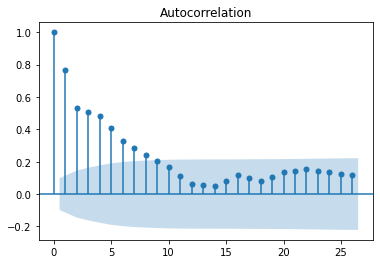

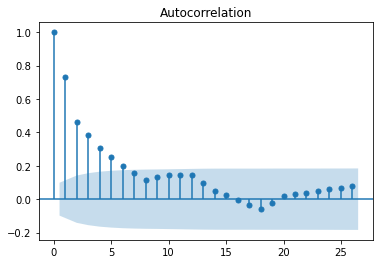

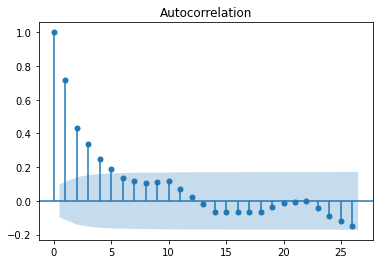

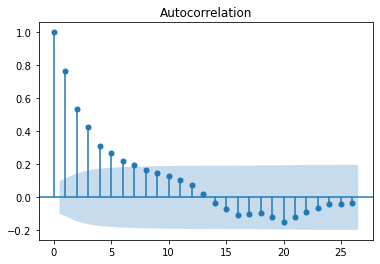

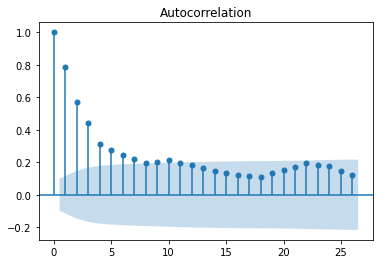

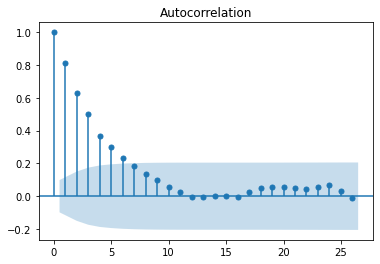

In [33]:
# Outputs in tex tabular style
def sig(a):
    if a < 0.01:
        return "***"
    elif a < 0.05:
        return "**"
    elif a < 0.1:
        return "*"
    return ""

#
for r in [0.8, 0.9, 0.99]: #0.8, 0.9, 0.99]: # values of rho to test
    for thresh in [1,2]:
        for i in range(len(ToOrder)):
            results = SafeRun(of="TSim", order=[ToOrder[i]], maxtime=maxtime, rho = r, r = thresh, simrep=simrep, ts=False, seed=seed)
            results = results[list(results.keys())[0]] #
            sim_per_queue = rearrange_for_test(results,i)
            del results
            gc.collect()
            f = io.StringIO()
            data_sim=np.array([(hsic.time_sampler(sim_per_queue[m], rng)) for m in range(ToOrder[i])])
            del sim_per_queue
            print(data_sim.shape)
            data_sim = np.mean(np.mean(data_sim, axis=0), axis=1)
            sm.graphics.tsa.plot_acf(data_sim, alpha=0.05)
            plt.savefig(f"output/{thresh}_{i}_{r}_{time.time()}.png")
            del data_sim
            gc.collect()


